# MAT281 - Laboratorio N°11

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [4]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics_regression import *


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [5]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv(os.path.join("data","interventionscitoyendo.csv"), sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [6]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


In [8]:
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objs as go

In [9]:
y_s1

,pdq
date,
2015-01-04,23.337079
2015-01-11,25.687861
2015-01-18,26.547170
2015-01-25,27.267016
2015-02-01,28.213018
...,...
2021-10-31,24.603306
2021-11-07,24.494949
2021-11-14,24.160000


In [77]:
validate_categorie

['Introduction',
 'Méfait',
 'Vol dans / sur véhicule à moteur',
 'Vol de véhicule à moteur']

estas son las diferentes opciones

In [15]:
# fix me please
fig = go.Figure([
    go.Scatter(
        name='precision media',
        x=y_s1.index,
        y=y_s1["pdq"],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
])
fig.update_layout(
    yaxis_title='cantidad de Introduction',
    xaxis_title='date',
    title='Introduction en el tiempo',
    hovermode="x"
)
fig.show()

In [17]:
fig = go.Figure([
    go.Scatter(
        name='precision media',
        x=y_s2.index,
        y=y_s2["pdq"],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
])
fig.update_layout(
    yaxis_title='cantidad de Méfait',
    xaxis_title='date',
    title='Méfait en el tiempo',
    hovermode="x"
)
fig.show()

In [12]:
fig = go.Figure([
    go.Scatter(
        name='precision media',
        x=y_s3.index,
        y=y_s3["pdq"],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
])
fig.update_layout(
    yaxis_title='cantidad de Vol dans / sur véhicule à moteur',
    xaxis_title='date',
    title='Vol dans / sur véhicule à moteur en el tiempo',
    hovermode="x"
)
fig.show()

In [20]:
fig = go.Figure([
    go.Scatter(
        name='precision media',
        x=y_s4.index,
        y=y_s4["pdq"],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
])
fig.update_layout(
    yaxis_title='cantidad de Vol de véhicule à moteur',
    xaxis_title='date',
    title='Vol de véhicule à moteur en el tiempo',
    hovermode="x"
)
fig.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realice un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [21]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

elegimos trabajar con y_s1

In [24]:
y_s1

,pdq
date,
2015-01-04,23.337079
2015-01-11,25.687861
2015-01-18,26.547170
2015-01-25,27.267016
2015-02-01,28.213018
...,...
2021-10-31,24.603306
2021-11-07,24.494949
2021-11-14,24.160000


In [27]:
y_s1.describe().T

,count,mean,std,min,25%,50%,75%,max
pdq,361.0,26.437394,1.658831,20.255319,25.227586,26.515873,27.61194,31.702479


In [52]:
print('Fecha Inicio: {}\nFecha Fin:    {}'.format(df.date.min(),df.date.max()))

Fecha Inicio: 2015-01-01 00:00:00
Fecha Fin:    2021-11-26 00:00:00


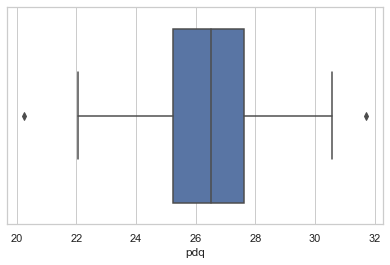

In [38]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=y_s1.pdq)

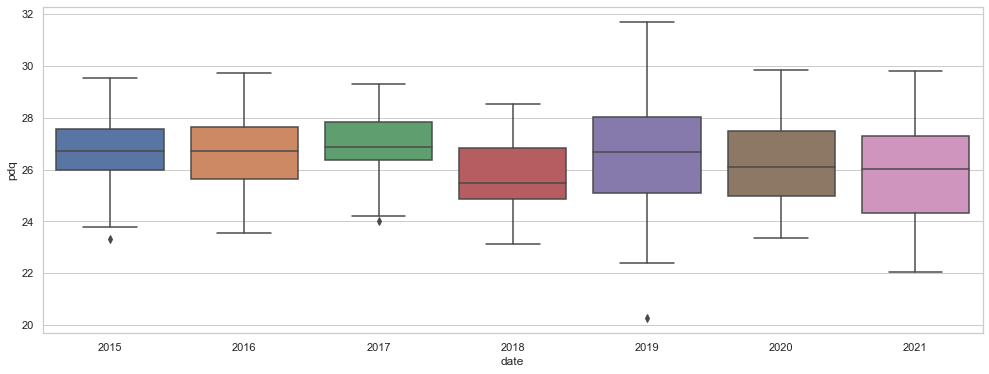

In [54]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y_s1.pdq.index.year, y_s1.pdq, ax=ax)
plt.show()

In [43]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

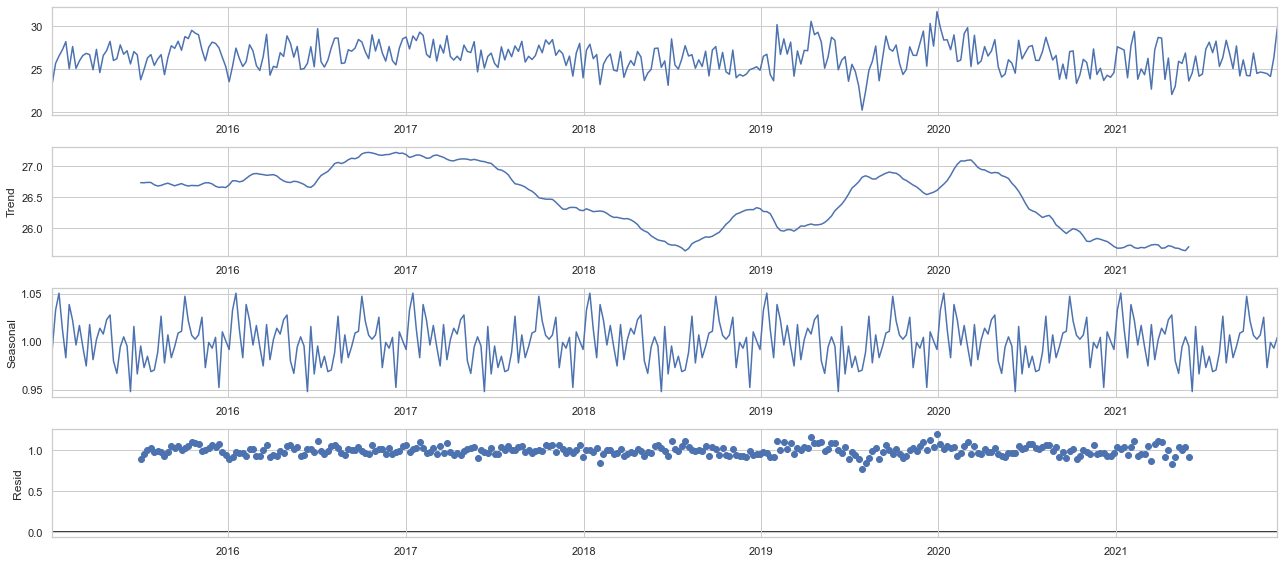

In [45]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s1, model='multiplicative')
fig = decomposition.plot()
plt.show()

notamos que el error se matiene cerca del 1 y podemos teorisar quee es un ruido blanco

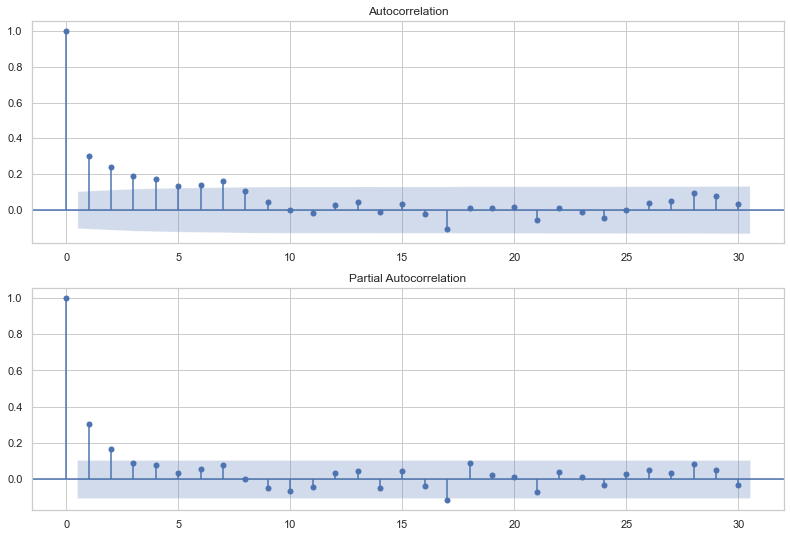

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(y_s1.pdq, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(y_s1.pdq, ax=pyplot.gca(), lags = 30)
pyplot.show()

la autocorrelacion igual es baja por lo que no se espera que  el modelo predisca muy bien

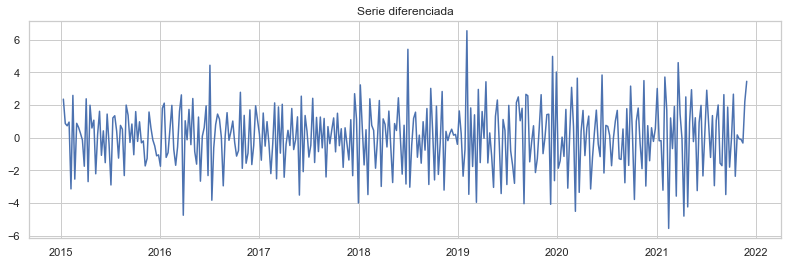

In [58]:
Y_diff = y_s1.diff()

rcParams['figure.figsize'] = 12, 4
plt.plot(Y_diff)
plt.title("Serie diferenciada")
plt.show()

In [59]:
def box_transformations(y,param):
    if param>0:
        return y.apply(lambda x: (x**(param)-1)/param)
    elif param==0:
        return np.log(y)
    else:
        print("lambda es negativo, se devulve la serie original")
        return y

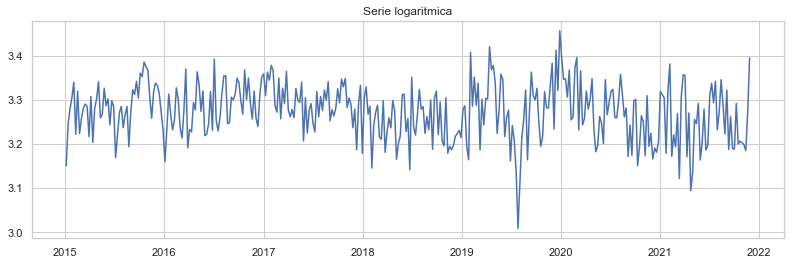

In [61]:
Y_log = box_transformations(y_s1,0)

rcParams['figure.figsize'] = 12, 4
plt.plot(Y_log)
plt.title("Serie logaritmica")
plt.show()

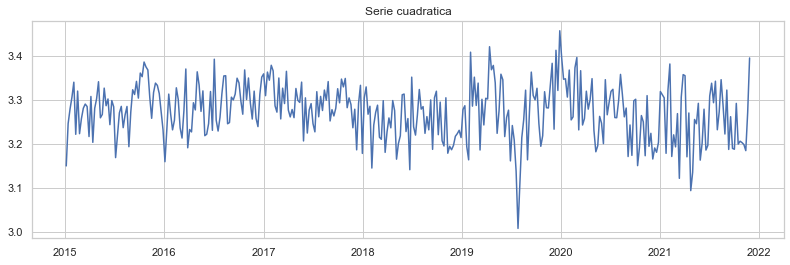

In [63]:
Y_quad = box_transformations(y_s1,2)

rcParams['figure.figsize'] = 12, 4
plt.plot(Y_log)
plt.title("Serie cuadratica")
plt.show()

ninguna de las transformaciones parece rentable

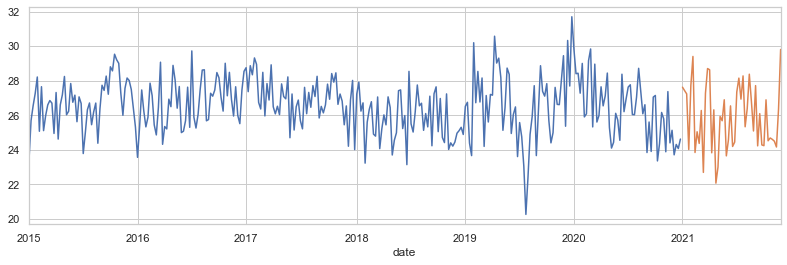

In [73]:
 target_date =  '2021-01-01'

# crear conjunto de entrenamiento y de testeo
mask_ds = y_s1.index < target_date

y_train = y_s1[mask_ds]
y_test = y_s1[~mask_ds]

#plotting the data
y_train['pdq'].plot()
y_test['pdq'].plot()
plt.show()

In [33]:
frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s1,target_date)
        frames.append(df_metrics)
    except:
        pass

In [39]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
0,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA_(0,0,1)X(1,0,1,12)"
0,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA_(1,0,0)X(1,0,1,12)"
0,1.6924,4.4958,2.1203,0.0646,0.0643,0.0654,0.0622,0.0655,"SARIMA_(0,0,0)X(1,1,0,12)"
0,1.7335,4.7229,2.1732,0.0646,0.0644,0.0670,0.0623,0.0672,"SARIMA_(1,1,1)X(0,0,0,12)"
...,...,...,...,...,...,...,...,...,...
0,7.8111,73.7850,8.5898,0.2988,0.2862,0.3019,0.2877,0.3654,"SARIMA_(1,1,0)X(0,1,0,12)"
0,22.8403,550.3448,23.4594,0.8845,0.7122,0.8827,0.8514,1.6822,"SARIMA_(0,0,1)X(0,0,1,12)"
0,23.0209,560.5370,23.6757,0.8899,0.7147,0.8896,0.8567,1.7030,"SARIMA_(0,0,0)X(0,0,1,12)"
0,25.5633,660.3857,25.6980,0.9886,0.7779,0.9879,0.9517,1.9706,"SARIMA_(0,0,1)X(0,0,0,12)"


como ordenamos por mape elegimos el primeer parametro porque es el con menor error mape

In [70]:
param = [(0,0,0),(1,0,1,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y_s1,target_date)
best_model = sarima_model.df_testig(y_s1,target_date)
best_model.head()

,y,yhat
2021-01-03,27.622449,26.158299
2021-01-10,27.425532,25.926903
2021-01-17,27.235294,26.083721
2021-01-24,24.012658,26.308888
2021-01-31,27.716418,26.074932


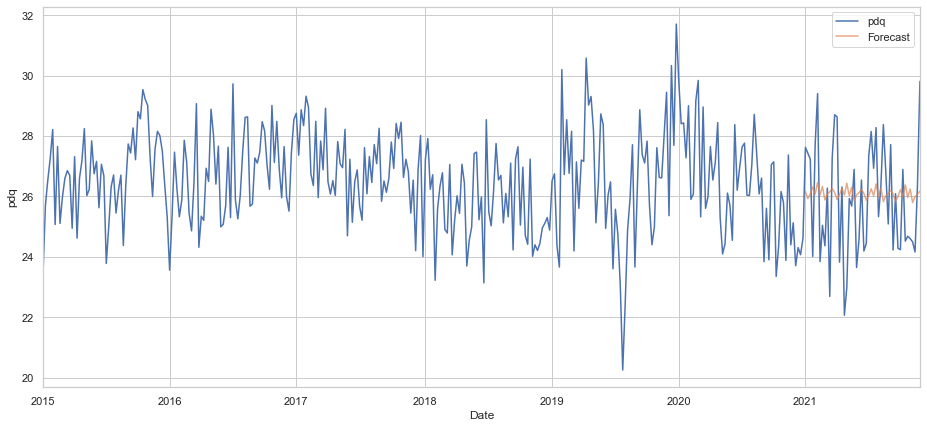

In [71]:
preds = best_model['yhat']
ax = y_s1['2015':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('pdq')
plt.legend()
plt.show()

vemos que la predicion no es ideal

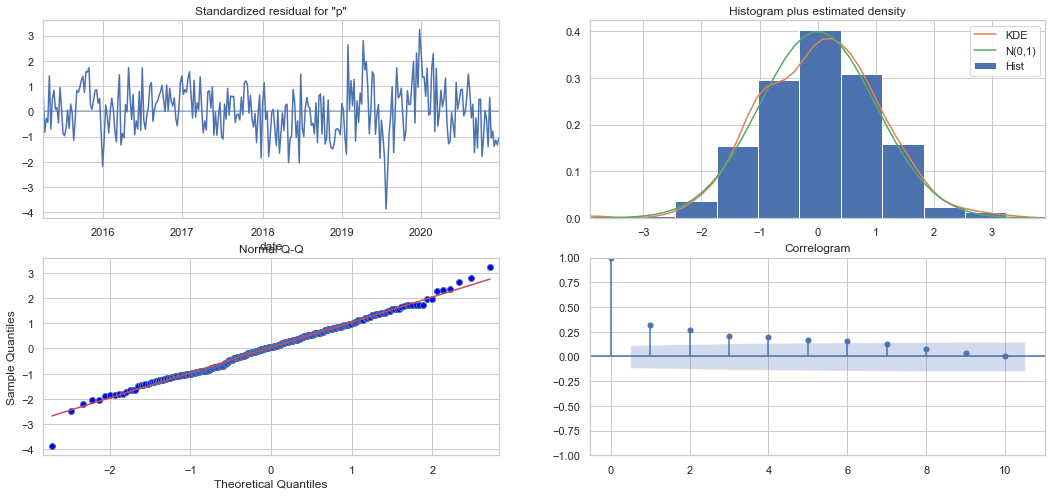

In [51]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

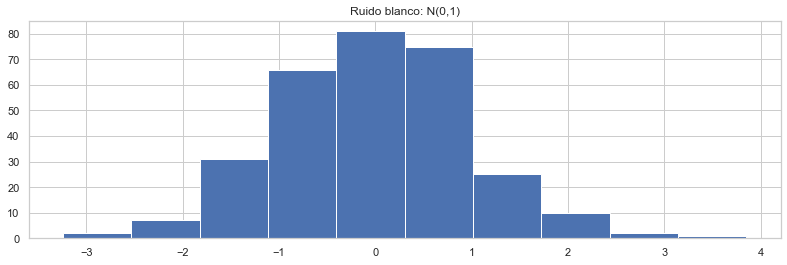

In [79]:
# grafico: histograma
np.random.seed(42) # fijar semilla

mean = 0
std = 1 
num_samples = 300


samples = np.random.normal(mean, std, size=num_samples)
plt.hist(samples,bins = 10)
plt.title("Ruido blanco: N(0,1)")
plt.show()

notamos que el segundo grafico de nuestro modelo  es muy similar al el histograma de un ruido blanco como el anterior por lo que el residuo es en eefecto un ruido blanco 